# Multicalsificacion ALL In One
## Eduardo Manuel Ceja Cruz


In [1]:
import fastai.vision.all as fv
import torch
import torch.nn as nn
import torch.nn.functional as F
import gc

from pathlib import Path
import random

## Cargamos los datos

In [2]:
path = Path('faces/')

In [3]:
files = path.ls(); files

(#16738) [Path('faces/0_adios_gato_0_01644.jpg'),Path('faces/0_adios_gato_0_03778.jpg'),Path('faces/0_adios_gato_0_15888.jpg'),Path('faces/0_adios_gato_0_21347.jpg'),Path('faces/0_adios_gato_0_23496.jpg'),Path('faces/0_adios_gato_0_24303.jpg'),Path('faces/0_adios_gato_0_31689.jpg'),Path('faces/0_adios_gato_0_55729.jpg'),Path('faces/0_adios_gato_0_62758.jpg'),Path('faces/0_adios_gato_1_08248.jpg')...]

In [4]:
def get_age(f):
    return float(f.name.split('_')[0])

In [5]:
def get_tag_1(f):
    return f.name.split('_')[1]

In [6]:
def get_tag_2(f):
    return f.name.split('_')[2]

In [7]:
def load_data(folder, img_size, batch_size):
    tfms = fv.aug_transforms(size = img_size,
                            flip_vert = False,
                            do_flip = False,
                            max_rotate = 10,
                            max_lighting =0.25,
                            max_zoom = 1.1,
                             max_warp = 0.1,
                             
                        )
    data = fv.DataBlock(blocks = (fv.ImageBlock, fv.RegressionBlock, fv.CategoryBlock, fv.CategoryBlock),
                        n_inp = 1,
                       get_items = fv.get_image_files,
                       get_y = [get_age, get_tag_1, get_tag_2], #esto necesita 3 funciones en lugar de una que regrese 3 cosas
                       splitter = fv.RandomSplitter(1/20),
                       item_tfms = fv.Resize(int(1.5 * img_size)),
                       batch_tfms =tfms,
                       )
    return data.dataloaders(folder, bs= batch_size)

30_puercoespin_gato_1_39610.jpg -> (30.0, 'puercoespin', 'gato')


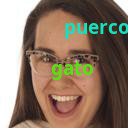

In [8]:
f = random.choice(files)
print(f"{f.name} -> {get_age(f), get_tag_1(f), get_tag_2(f)}")
fv.PILImage.create(f)

In [9]:
data = load_data(path, img_size=192, batch_size=128)

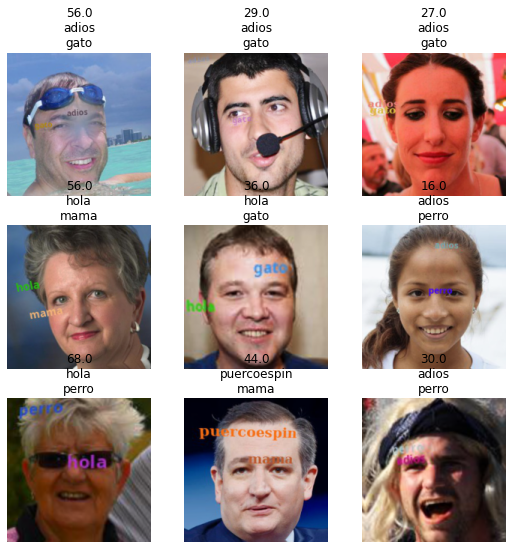

In [10]:
data.show_batch()

### Vemos como vienen los datos

In [11]:
x, y, z, v = data.one_batch()

In [12]:
x.shape

torch.Size([128, 3, 192, 192])

In [13]:
y.shape

torch.Size([128])

In [14]:
z.shape

torch.Size([128])

In [15]:
v.shape

torch.Size([128])

## Creamos las cosas para el modelo

In [16]:
class Normalizer(nn.Module):
    def __init__(self, mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]): #stats de Image Net
        super().__init__()
        self.mean = torch.tensor(mean)[None,:,None,None]
        self.std  = torch.tensor(std)[None,:,None,None]
        
    def forward(self, x):
        m = self.mean.to(x)
        s = self.std.to(x)
        return (x - m)/s

In [17]:
class FullFlatten(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return x.reshape(-1)

In [18]:
def l1_flat(yp, y):
    yp = yp.view(-1)
    return F.l1_loss(yp, y)

In [19]:
def mse_flat(yp, y):
    yp = yp.view(-1)
    return F.mse_loss(yp , y)

In [20]:
def sqrt_mse_flat(yp, y):
    yp = yp.view(-1)
    return torch.sqrt(F.mse_loss(yp, y))

In [21]:
def resnet_split(m):
    return fv.L(m[:6], m[6:-8], m[-8:]).map(fv.params)

In [22]:
def create_learner(**kwargs):
    layers = [Normalizer()] # para no nornalizar los datos, normalizamos directamnte en el modelo
    layers += list(fv.resnet18(pretrained = True).children())[:-2] # usar resnet para no entrenar de nuevo
    head = fv.create_head(1024,8, ps = 0.4)
    head[5] = nn.LeakyReLU()
    layers += list(head)
    layers += [FullFlatten()]
    model = nn.Sequential(*layers)
    learn = fv.Learner(data, model, opt_func = fv.ranger, splitter = resnet_split, **kwargs)
    learn.freeze()
    gc.collect()
    return learn.to_fp16()

In [23]:
class AgeLimiter(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return torch.sigmoid(x)*117 - 0.5

El age limiter no lo utilize

In [24]:
gc.collect()

433

In [25]:
def loss_func(yp, y):
    return l1_flat(yp, y) + F.binary_cross_entropy_with_logits(yp, y) + F.binary_cross_entropy_with_logits(yp, y)

In [26]:
def loss_func(yp, y, sign_1, signp_1, sign_2, signp_2):
    yp = yp.view(-1)
    signp_1 = signp_1.view(-1)
    signp_2 = signp_2.view(-1)
    return l1_flat(yp, y) + F.binary_cross_entropy_with_logits(signp_1, sign_1) + F.binary_cross_entropy_with_logits(signp_2, sign_2)

La funcion que termine usando es la que esta aqui que se llama `loss_func_all` las anteriores o me daban error o me daban cosas que ni al caso pero las decidi dejar por documentaion de lo que hice

In [36]:
def loss_func_all(preds, age, sign1, sign2):
#     print(yp, y, sign1, sign2)
    preds = torch.reshape(preds, (age.shape[0], 8)) 
#     print(preds.shape)
    loss0 =F.l1_loss(preds[:, 0], age) 
    # loss1 = 10 * F.binary_cross_entropy_with_logits(preds[:, 1:4], sign1) #usar con logits porque usa sigmoide
    loss1 = F.cross_entropy(preds[:, 1:4], sign1) # BCE logits usa sigmoide asi que mejor cross entropy
    loss2 = F.cross_entropy(preds[:, 4:], sign2)
    # loss2 = 10*F.binary_cross_entropy_with_logits(preds[:, 4:], sign2)
#     print (loss0, loss1, loss2)
    return  loss0/30 + loss1 + loss2

experiomento spara el reshape

In [28]:
a = torch.randint(0, 10, (3,3));a

tensor([[9, 0, 4],
        [4, 6, 1],
        [0, 0, 7]])

In [29]:
a.shape[0]

3

In [30]:
b = torch.arange(6.); b

tensor([0., 1., 2., 3., 4., 5.])

In [31]:
torch.reshape(b, (2,3))

tensor([[0., 1., 2.],
        [3., 4., 5.]])

Las metricas que le pase al learner, son las mismas que utilice para crearlo

In [53]:
def metric_l1(preds,age, sign1, sign2):
    preds = torch.reshape(preds,(age.shape[0], 8))
    return F.l1_loss(preds[:, 0], age)

In [54]:
# def accuracy_age(preds,age, sign1, sign2):
#     preds = torch.reshape(preds,(age.shape[0], 8))
#     return fv.accuracy(preds[:, 0], age)

In [55]:
def accuracy_sign1(preds, age, sign1, sign2):
    preds = torch.reshape(preds, (age.shape[0], 8))
    return (fv.accuracy(preds[:, 1:4], sign1))

In [56]:
def accuracy_sign2(preds, age, sign1, sign2):
    preds = torch.reshape(preds, (age.shape[0], 8))
    return (fv.accuracy(preds[:, 4:], sign2))

In [57]:
# metrics = [F.l1_loss, F.binary_cross_entropy_with_logits, F.binary_cross_entropy_with_logits]

# metrics = [fv.accuracy_multi]

metrics = [metric_l1, accuracy_sign1, accuracy_sign2]

## Crear el learner

In [58]:
learn = create_learner(loss_func = loss_func_all, metrics = metrics)

In [33]:
learn.model

Sequential(
  (0): Normalizer()
  (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (5): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True

In [34]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,metric_l1,accuracy_sign1,accuracy_sign2,time
0,33.452991,33.515022,31.030306,0.434211,0.260766,00:18


tensor(28.7660, device='cuda:0', grad_fn=<L1LossBackward>) tensor(1.3025, device='cuda:0', grad_fn=<NllLossBackward>) tensor(1.6438, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(31.9382, device='cuda:0', grad_fn=<L1LossBackward>) tensor(1.2465, device='cuda:0', grad_fn=<NllLossBackward>) tensor(1.5284, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(32.6554, device='cuda:0', grad_fn=<L1LossBackward>) tensor(1.2065, device='cuda:0', grad_fn=<NllLossBackward>) tensor(1.5801, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(31.2865, device='cuda:0', grad_fn=<L1LossBackward>) tensor(1.2577, device='cuda:0', grad_fn=<NllLossBackward>) tensor(1.5290, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(29.0485, device='cuda:0', grad_fn=<L1LossBackward>) tensor(1.2210, device='cuda:0', grad_fn=<NllLossBackward>) tensor(1.5395, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(29.7043, device='cuda:0', grad_fn=<L1LossBackward>) tensor(1.1205, device='cuda:0', grad_fn=<NllLossBackward

In [42]:
learn.validate()

(#4) [3.787957191467285,30.712831497192383,0.32894736528396606,0.2631579041481018]

Vimos que hay que dividir metric_l1 entre 30 para que sea razonable esto y esten todos cerca de 1

Ahora ya que tenemos todo esto, podemos empezar a entrenar

SuggestedLRs(lr_min=0.00831763744354248, lr_steep=1.2022644114040304e-05)

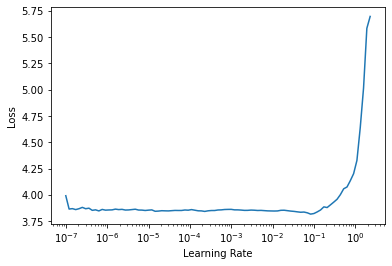

In [59]:
learn.lr_find()

In [60]:
learn.fit_one_cycle(20, 8e-3, div =0.9, pct_start = 0.75)

epoch,train_loss,valid_loss,metric_l1,accuracy_sign1,accuracy_sign2,time
0,3.207647,2.972512,30.255320,0.662679,0.367225,00:16
1,2.569685,2.328638,20.584068,0.765550,0.500000,00:16
2,1.855210,1.722879,11.449504,0.803828,0.622010,00:16
3,1.624511,1.797831,13.908958,0.827751,0.630383,00:17
4,1.503527,1.488389,9.847953,0.867225,0.660287,00:17
5,1.420119,1.406956,9.777873,0.868421,0.698565,00:18
6,1.381949,1.420809,9.573586,0.872010,0.688995,00:17
7,1.335422,1.339959,9.004068,0.867225,0.710526,00:16
8,1.322366,1.326217,9.180112,0.877990,0.711722,00:17
9,1.278522,1.438611,9.492150,0.875598,0.666268,00:17


Vemos que aun no tenemos muy buena prediccion de edad ni del segundo letrero asi que vamos a entrenar unas cuantas epocas mas. Tambien peudo decir que se puede porque no se ve que el modelo este haciendo overfit (viendo train_loss y valid_loss estan casi igual)

In [61]:
learn.fit_one_cycle(30, 5e-3, div =0.9, pct_start = 0.75)

epoch,train_loss,valid_loss,metric_l1,accuracy_sign1,accuracy_sign2,time
0,1.084119,1.127477,7.860701,0.912679,0.754785,00:16
1,1.091002,1.149469,8.137154,0.899522,0.751196,00:17
2,1.081125,1.132832,8.210971,0.905502,0.754785,00:18
3,1.079941,1.157822,7.934152,0.891148,0.728469,00:17
4,1.071713,1.205672,8.280926,0.909091,0.722488,00:18
5,1.052137,1.152323,7.942784,0.883971,0.752392,00:18
6,1.060031,1.155203,8.162817,0.887560,0.753588,00:18
7,1.062464,1.131586,7.846469,0.899522,0.751196,00:18
8,1.055280,1.128050,7.832888,0.907895,0.735646,00:18
9,1.042462,1.167894,8.078532,0.893541,0.738038,00:17


Las accuracys para las etiquetas se ve que estan relativamente bien, en el de 3 falla un poco pero no esta tan mal, y para la edad nos arroja la metrica l1 un error de  $\pm 7$ en la edad lo cual pues es malo pero siento que es rasonable para edades avanzadas.

In [46]:
learn.validate()

(#4) [0.819111704826355,10.052315711975098,0.9126794338226318,0.7882775068283081]

## Contruir el `show_results`

In [63]:
def show_results(self, max_n = 16):
    dl = self.dls.valid.new(suffle = True)
    x,y,z,v = dl.one_batch() 
    preds = self.model(x).view(-1)
    ctx = fv.get_grid(max_n)
    preds = torch.reshape(preds, (y.shape[0], 8))
    for i in range(max_n):
#         print(preds.shape)
#         raise
        age = preds[i, 0]
        sign1 = preds[i, 1:4]
#         print(sign1)
        sign2 = preds[i, 4:]
#         print(sign2)
        fv.show_image(x[i], ctx = ctx[i], title = f"{age:.1f} | {int(y[i])} \n sign1 {sign1.argmax()} | {z[i]} sign2 {sign2.argmax()} | {v[i]}")

In [64]:
fv.Learner.show_results = show_results

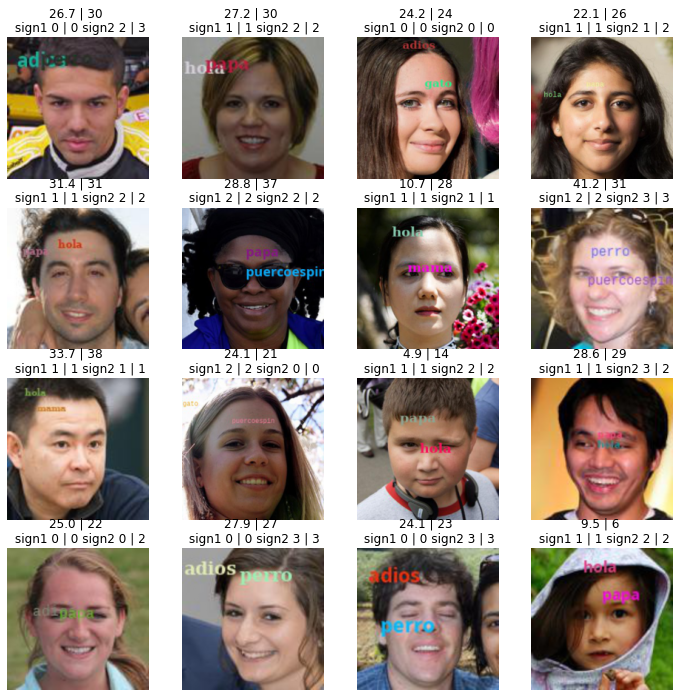

In [65]:
learn.show_results()

In [67]:
learn.validate()

(#4) [1.0526361465454102,7.398497104644775,0.9186602830886841,0.7631579041481018]

Vemos que en la edad no esta tan buena, pero en general, creo que no le fue tan mal, las etiquetas las regrese asi porque no se como estan otrdenados los datos(suponog que por orden alfabetico), pero se que regresan indices por lo que creo que se puede cambiar, tal vez la encuentres debajo de esto lo que si es que me consume mucha vram hacer una nueva funcion de show results mientras estaba haciendo los experimentos y tuve que reiniciar el kernel varias veces. 